In [ ]:
%cd "/content/drive/MyDrive/kaggle/boston_house_price"

/content/drive/MyDrive/kaggle/boston_house_price


In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 10.8 MB/s eta 0:00:00


In [ ]:
# data analytics
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline

from IPython.display import Image

import warnings
warnings.filterwarnings('ignore')

# math
import scipy
from scipy import stats
from scipy.stats import norm
from scipy.stats import levene
from scipy.stats import skew, kurtosis
import scipy as sp
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor

# preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# model
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score


In [ ]:
df = pd.read_csv('1st_train_mdf.csv')

# 종속변수 SalePrice

In [ ]:
df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Text(0.5, 1.0, 'Distribution of SalePrice')

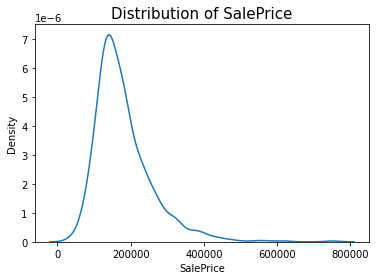

In [ ]:
# SalePrice의 kdeplot
sns.kdeplot(df['SalePrice'])
plt.title("Distribution of SalePrice", fontsize = 15)

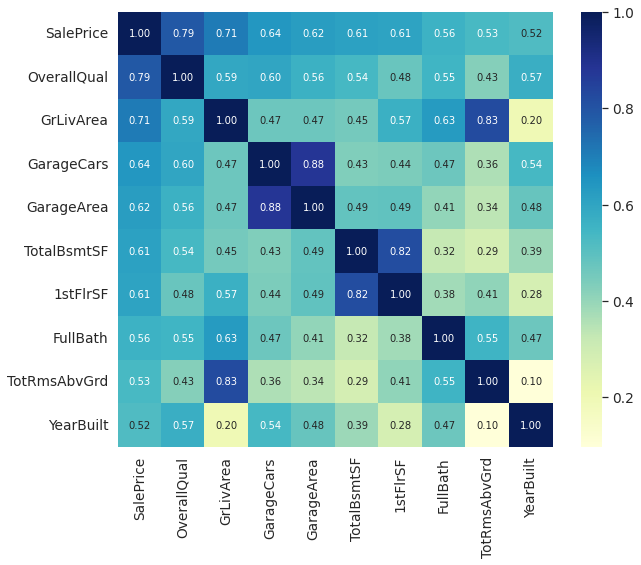

In [ ]:
# 상관관계 히트맵
k = 10 #number of variables for heatmap
cor = df.corr()
cols = cor.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
plt.figure(figsize=(10,8))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values, cmap='YlGnBu')
plt.show()

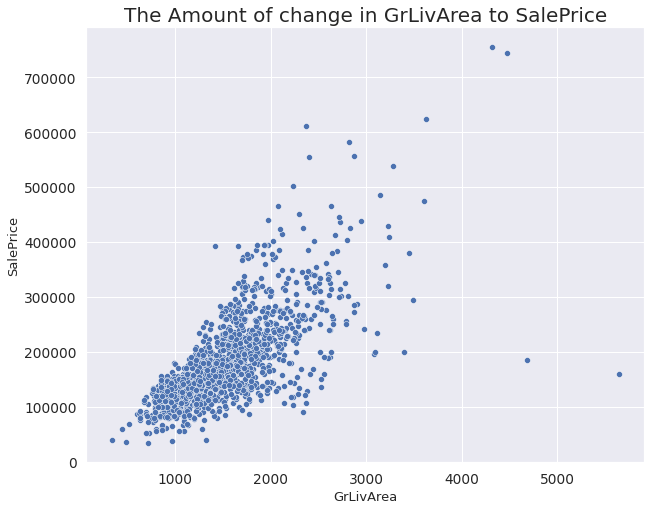

In [ ]:
# SalePrice와 GrLivArea, OverallQual의 scatterplot
plt.figure(figsize = (10, 8))
sns.scatterplot(x = df['GrLivArea'], y = df['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.title("The Amount of change in GrLivArea to SalePrice", fontsize = 20)
plt.show()

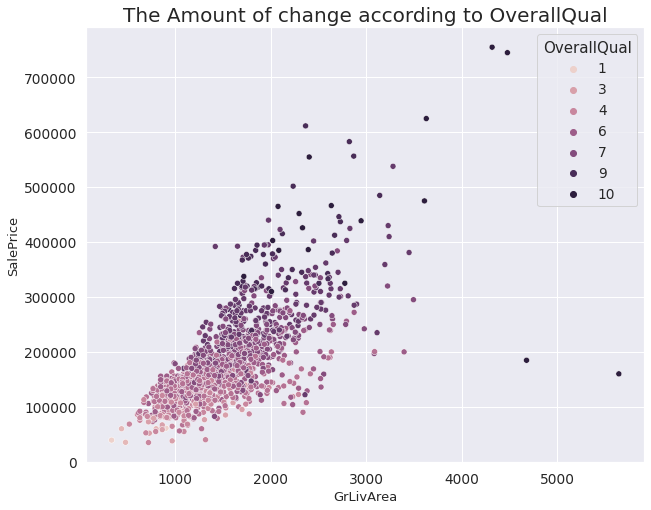

In [ ]:
plt.figure(figsize = (10, 8))
sns.scatterplot(x = df['GrLivArea'], y = df['SalePrice'], hue = df['OverallQual'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.title("The Amount of change according to OverallQual", fontsize = 20)
plt.show()

In [ ]:
df['TotalPorch'] = df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']

train_df = df.drop(['Id', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 
                    '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
                    'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch'], axis = 1, inplace = False)


In [ ]:
num = ['MSSubClass', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'MoSold', 'YrSold']

for col in num:
  train_df[col] = train_df[col].astype('str')


In [ ]:
train_df['BsmtExposure'][948] = 'GLQ'
train_df['BsmtFinType2'][332] = 'Unf'

train_df['PoolQC'] = train_df['PoolQC'].fillna('No Pool')
train_df['MiscFeature'] = train_df['MiscFeature'].fillna('None')
train_df['Alley'] = train_df['Alley'].fillna('No Alley')
train_df['Fence'] = train_df['Fence'].fillna('Fence')
train_df['FireplaceQu'] = train_df['FireplaceQu'].fillna('No Fireplace')
train_df['LotFrontage'] = train_df['LotFrontage'].fillna(train_df['LotFrontage'].median())
train_df['GarageType'] = train_df['GarageType'].fillna('No Garage')
train_df['GarageYrBlt'] = train_df['GarageYrBlt'].fillna('No Garage') # YearBuilt와 같은 값으로 채워려했으나 Garage가 없음
train_df['GarageFinish'] = train_df['GarageFinish'].fillna('No Garage')
train_df['GarageQual'] = train_df['GarageQual'].fillna('No Garage')
train_df['GarageCond'] = train_df['GarageCond'].fillna('No Garage')
train_df['BsmtExposure'] = train_df['BsmtExposure'].fillna('No Basement')
train_df['BsmtFinType2'] = train_df['BsmtFinType2'].fillna('No Basement')
train_df['BsmtFinType1'] = train_df['BsmtFinType1'].fillna('No Basement')
train_df['BsmtQual'] = train_df['BsmtQual'].fillna('No Basement')
train_df['BsmtCond'] = train_df['BsmtCond'].fillna('No Basement')
train_df['MasVnrType'] = train_df['MasVnrType'].fillna('None')
train_df['MasVnrArea'] = train_df['MasVnrArea'].fillna(0)
train_df['Electrical'] = train_df['Electrical'].fillna(train_df['Electrical'].mode()[0])

In [ ]:
train_df['BsmtFullBath'] = train_df['BsmtFullBath'].astype('str')
train_df['BsmtHalfBath'] = train_df['BsmtHalfBath'].astype('str')
train_df['FullBath'] = train_df['FullBath'].astype('str')
train_df['HalfBath'] = train_df['HalfBath'].astype('str')
train_df['BedroomAbvGr'] = train_df['BedroomAbvGr'].astype('str')
train_df['KitchenAbvGr'] = train_df['KitchenAbvGr'].astype('str')
train_df['TotRmsAbvGrd'] = train_df['TotRmsAbvGrd'].astype('str')
train_df['Fireplaces'] = train_df['Fireplaces'].astype('str')
train_df['GarageCars'] = train_df['GarageCars'].astype('str')


In [ ]:
num_cols = train_df.select_dtypes(exclude = "object").columns
cat_cols = train_df.select_dtypes(include = 'object').columns


In [ ]:
def remove_out(dataframe, remove_col):
    dff = dataframe
    for k in remove_col:
        level_1q = dff[k].quantile(0.25)
        level_3q = dff[k].quantile(0.75)
        IQR = level_3q - level_1q
        rev_range = 3  # 제거 범위 조절 변수
        dff = dff[(dff[k] <= level_3q + (rev_range * IQR)) & (dff[k] >= level_1q - (rev_range * IQR))]
        dff = dff.reset_index(drop=True)
    return dff

In [ ]:
df_out = remove_out(train_df, num_cols)

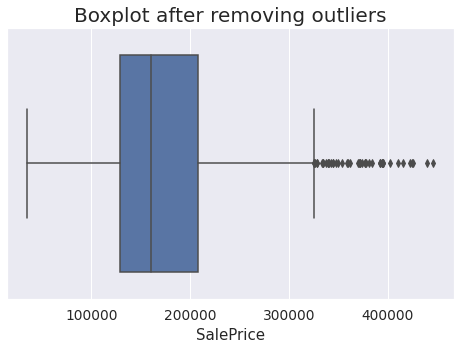

In [ ]:
plt.figure(figsize = (8, 5))
sns.boxplot(df_out['SalePrice'])
plt.title("Boxplot after removing outliers", fontsize = 20)
plt.show()

In [ ]:
from scipy.stats import skew, kurtosis

for col in num_cols:
  print(col, "\n왜도 : ", skew(train_df[col]), '\n첨도 : ', kurtosis(train_df[col]))
  print("--------------------------")

LotFrontage 
왜도 :  2.4066708091473084 
첨도 :  21.83387498211393
--------------------------
LotArea 
왜도 :  12.195142125084478 
첨도 :  202.5437927513529
--------------------------
MasVnrArea 
왜도 :  2.6748646898037354 
첨도 :  10.102611811101848
--------------------------
TotalBsmtSF 
왜도 :  1.522688086978629 
첨도 :  13.201041630635025
--------------------------
GrLivArea 
왜도 :  1.365155954773434 
첨도 :  4.874265760253215
--------------------------
GarageArea 
왜도 :  0.1797959420587727 
첨도 :  0.9098227950882034
--------------------------
WoodDeckSF 
왜도 :  1.5397916998042025 
첨도 :  2.978604140391349
--------------------------
PoolArea 
왜도 :  14.813134660429398 
첨도 :  222.500506832132
--------------------------
MiscVal 
왜도 :  24.4516396173223 
첨도 :  698.6008400387273
--------------------------
TotalPorch 
왜도 :  1.9979731363673292 
첨도 :  7.246542549209877
--------------------------


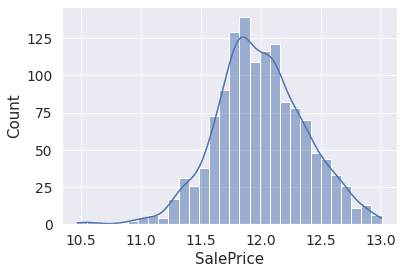

In [ ]:
df_out['SalePrice'] = np.log1p(df_out['SalePrice'])
sns.histplot(df_out['SalePrice'], kde=True)

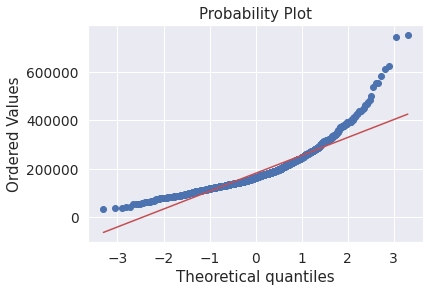

In [ ]:
# QQ-plot 확인
fig = plt.figure()
res = stats.probplot(train_df['SalePrice'], plot=plt)
plt.show()

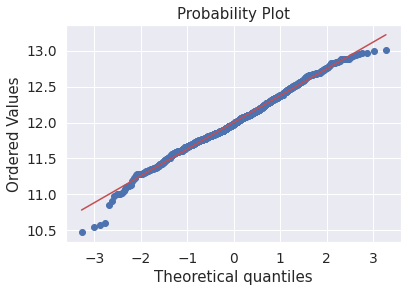

In [ ]:
# QQ-plot 확인
fig = plt.figure()
res = stats.probplot(df_out['SalePrice'], plot=plt)
plt.show()

# 독립변수, 종속변수

In [ ]:
y = df_out['SalePrice'] # 종속변수
X = df_out.drop('SalePrice', axis = 1, inplace = False) # 독립변수

In [ ]:
# 수치형 변수, 순서형 변수, 명목형 변수
num_cols = X.select_dtypes(exclude = "object").columns
ord_cols = ['OverallCond', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'MoSold', 'YrSold',
            'LotShape', 'LandSlope', 'ExterQual', 'ExterCond',
           'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond',
           'PoolQC', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Functional', 'GarageFinish', 'Fence']
cat_cols = ['MSSubClass', 'Street', 'Alley',  'LandContour',
       'Utilities', 'LotConfig', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 
       'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'Foundation',
       'Heating', 'CentralAir', 'Electrical', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
        'TotRmsAbvGrd', 'Fireplaces',
        'GarageType',
       'GarageCars', 'PavedDrive', 
       'MiscFeature', 'SaleType',
       'SaleCondition', 'MSZoning']

In [ ]:
# model1 = sm.OLS.from_formula("SalePrice ~ " + "+".join(X.columns), data = df_out)
# result1 = model1.fit()
# print(result1.summary())

In [ ]:
for col in ord_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

In [ ]:
X = pd.get_dummies(X)

In [ ]:
for col in num_cols:
  X[col] = np.log1p(X[col])

In [ ]:
dfX0 = pd.DataFrame(X, columns=X.columns)
dfX = sm.add_constant(dfX0) # 상수항 추가
dfy = pd.DataFrame(y, columns=['SalePrice'])

In [ ]:
df = pd.concat([dfX, dfy], axis=1)

In [ ]:
model_boston = sm.OLS(dfy, dfX)
result_boston = model_boston.fit()
print(result_boston.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     77.18
Date:                Fri, 17 Feb 2023   Prob (F-statistic):               0.00
Time:                        01:45:58   Log-Likelihood:                 1287.2
No. Observations:                1322   AIC:                            -2128.
Df Residuals:                    1099   BIC:                            -971.7
Df Model:                         222                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.76

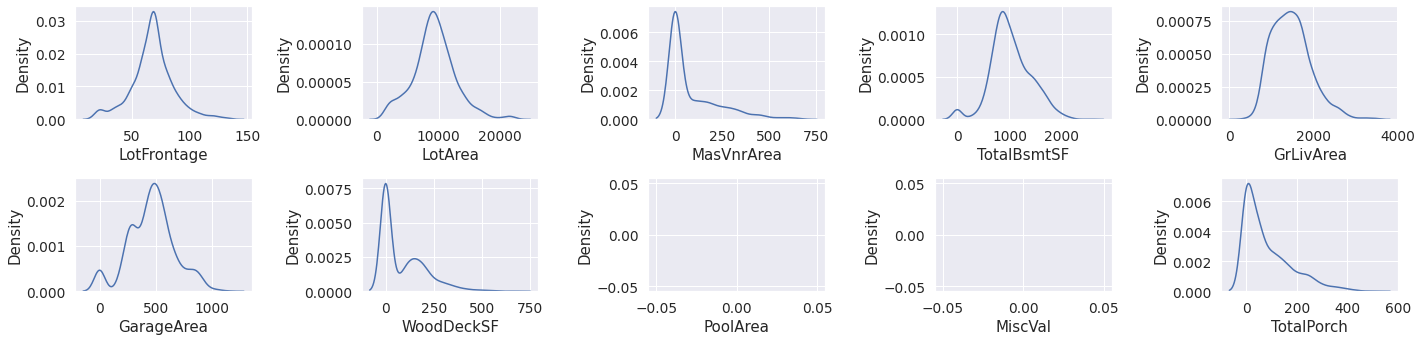

In [ ]:
plt.figure(figsize=(20, 5))
for i in range(len(num_cols)):
    plt.subplot(2, 5, i+1)
    sns.kdeplot(df_out[num_cols[i]])
plt.tight_layout()

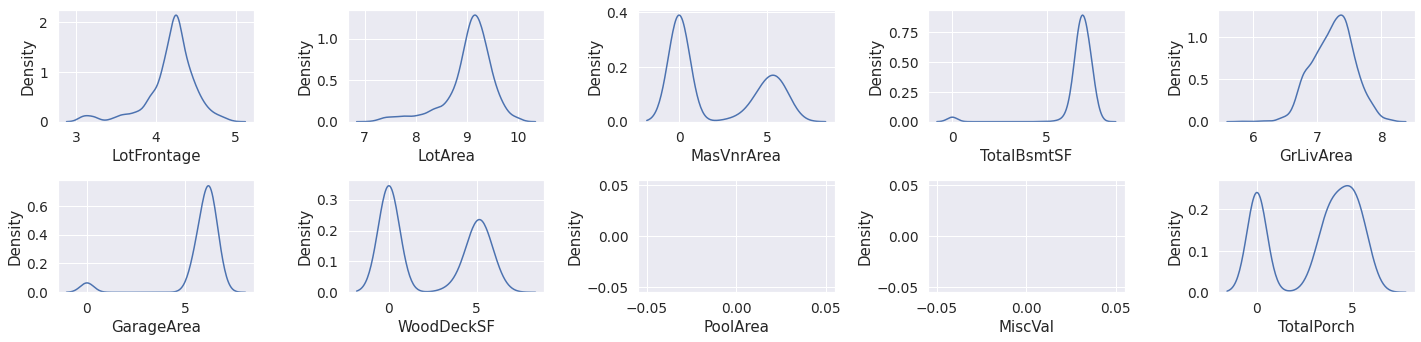

In [ ]:
plt.figure(figsize=(20, 5))
for i in range(len(num_cols)):
    plt.subplot(2, 5, i+1)
    sns.kdeplot(X[num_cols[i]])
plt.tight_layout()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.2, random_state=40) #y는 로그변환된 상태임.


ValueError: ignored

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

# 회귀분석 가정

In [ ]:
#### 선형 회귀 모델 ####
lr = LinearRegression()
lr.fit(X_train, y_train) 
y_predict = lr.predict(X_test)

RMSE = mean_squared_error(y_test, y_predict)**0.5
print(RMSE)

0.11986450970635866


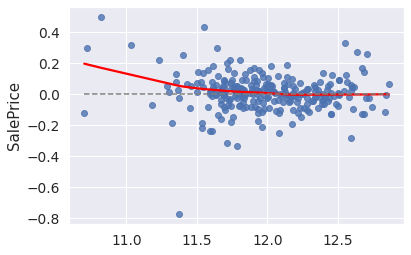

In [ ]:
# 회귀분석 가정1) 선형성
residual = y_test - y_predict 
sns.regplot(y_predict, residual, lowess=True, line_kws={'color':'red'})
plt.plot([y_predict.min(), y_predict.max()], [0, 0], '--', color='grey')


ShapiroResult(statistic=0.910727322101593, pvalue=1.837699784013047e-11)

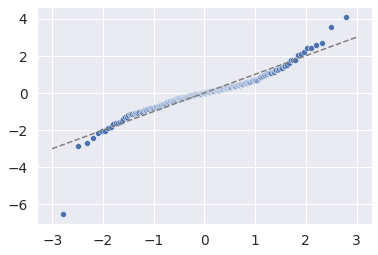

In [ ]:
# 회귀분석 가정2) 정규성
import scipy

residual = y_test - y_predict 

sr = scipy.stats.zscore(residual)
(x, y), _ = scipy.stats.probplot(sr)
sns.scatterplot(x, y)
plt.plot([-3, 3], [-3,3], '--', color='grey')
scipy.stats.shapiro(residual)

In [ ]:
scipy.stats.shapiro(residual)

ShapiroResult(statistic=0.910727322101593, pvalue=1.837699784013047e-11)

LeveneResult(statistic=0.017059007265419545, pvalue=0.8961334714193827)

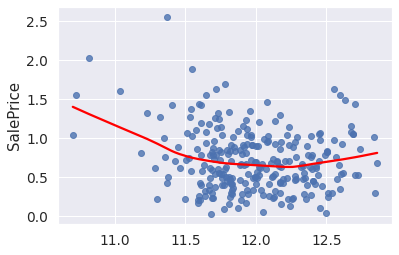

In [ ]:
# 회귀분석 가정3) 등분산성
sns.regplot(y_predict, np.sqrt(np.abs(sr)), lowess=True, line_kws={'color':'red'})
levene(y_predict, np.sqrt(np.abs(sr)))

In [ ]:
from scipy.stats import levene
levene(y_predict, np.sqrt(np.abs(sr)))

LeveneResult(statistic=0.017059007265419545, pvalue=0.8961334714193827)

In [ ]:
# 회귀분석 가정4) 독립성
dw = durbin_watson(residual)
print(f"Durbin-Watson: {dw}")

Durbin-Watson: 2.2189662834934665


In [ ]:
def get_rmses(models):
  rmses = []
  for model in models:
    pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    print(model.__class__.__name__, '로그 변환된 RMSE : ', np.round(rmse, 4))
    rmses.append(rmse)
  return rmses

In [ ]:
def get_r2(models):
  for model in models:
    # print("Coefficient : ", model.coef_, "\nIntercept : ", model.intercept_)
    print(model.__class__.__name__)
    print("train(cv) R2_score : ", r2_score(y_train, model.predict(X_train)))
    print("test(cv) R2_score : ", r2_score(y_test, model.predict(X_test)))
    print("-------------------------")

# 모델링

In [ ]:
ridge = Ridge()
ridge.fit(X_train, y_train)

Ridge()

In [ ]:
lasso = Lasso()
lasso.fit(X_train, y_train)

Lasso()

In [ ]:
models = [lr, ridge, lasso]

In [ ]:
get_rmses(models)
get_r2(models)

LinearRegression 로그 변환된 RMSE :  0.1199
Ridge 로그 변환된 RMSE :  0.1111
Lasso 로그 변환된 RMSE :  0.2881
LinearRegression
train(cv) R2_score :  0.9403049268462024
test(cv) R2_score :  0.9056676915479676
-------------------------
Ridge
train(cv) R2_score :  0.9384031901486578
test(cv) R2_score :  0.9189675941117075
-------------------------
Lasso
train(cv) R2_score :  0.4142944203706268
test(cv) R2_score :  0.45492445392467074
-------------------------


In [ ]:
def print_best_params(model, params):
  grid_model = GridSearchCV(model, param_grid = params, scoring = 'neg_mean_squared_error', cv = 5)
  grid_model.fit(X, y)
  rmse = np.sqrt(-1 * grid_model.best_score_)
  print('{0} 5 CV 시 로그 변환된 최적의 평균 RMSE 값: {1}, 최적 alpha: {2}'.format(model.__class__.__name__, np.round(rmse, 4), grid_model.best_params_))
  # return grid_model.best_estimator_

In [ ]:
# ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
# lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
# best_ridge = print_best_params(ridge, ridge_params)
# best_lasso = print_best_params(lasso, lasso_params)

In [ ]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge(alpha = 5)
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso(alpha = 0.001)
lasso_reg.fit(X_train, y_train)

Lasso(alpha=0.001)

In [ ]:
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)
get_r2(models)

LinearRegression 로그 변환된 RMSE :  0.1199
Ridge 로그 변환된 RMSE :  0.1095
Lasso 로그 변환된 RMSE :  0.1147
LinearRegression
train(cv) R2_score :  0.9403049268462024
test(cv) R2_score :  0.9056676915479676
-------------------------
Ridge
train(cv) R2_score :  0.9321949726989155
test(cv) R2_score :  0.9213361111719607
-------------------------
Lasso
train(cv) R2_score :  0.9145181537095194
test(cv) R2_score :  0.9135740396319293
-------------------------


In [ ]:
def get_top_bottom_coef(model):
   
    coef = pd.Series(model.coef_, index=X.columns)
    coef_high = coef.sort_values(ascending=False).head(10)
    coef_low = coef.sort_values(ascending=False).tail(10)
    return coef_high, coef_low

In [ ]:
def visualize_coefficient(models):

    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=3)
    fig.tight_layout() 
 
    for i_num, model in enumerate(models):
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat( [coef_high , coef_low] )
       
        axs[i_num].set_title(model.__class__.__name__+' Coefficents', size=25)
        axs[i_num].tick_params(axis="y",direction="in", pad=-120)
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index , ax=axs[i_num])


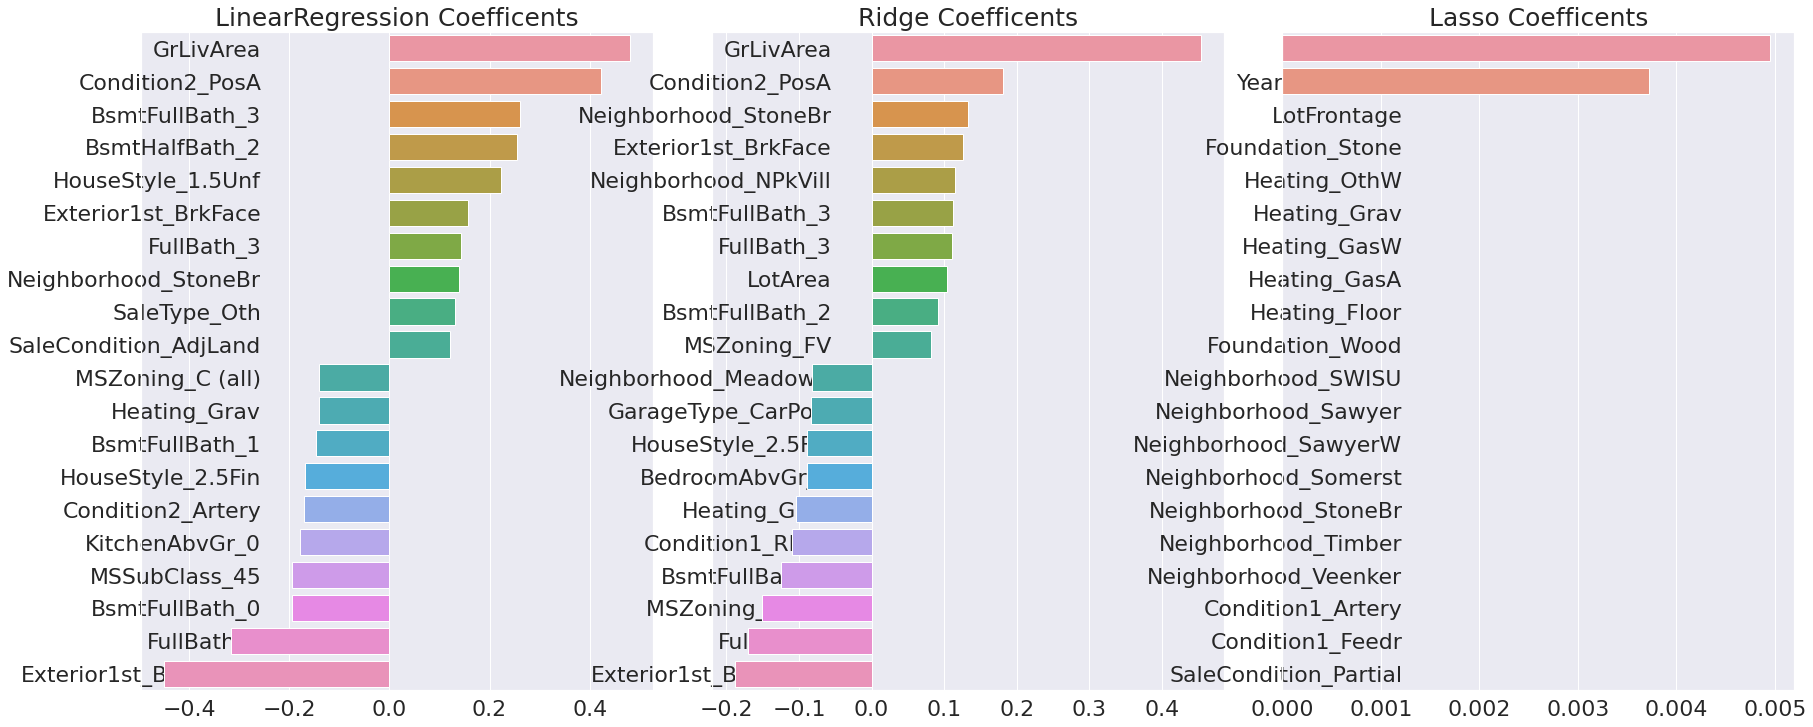

In [ ]:
# GridSearchCV 전과 후 시각화
models = [lr, ridge, lasso]
visualize_coefficient(models)

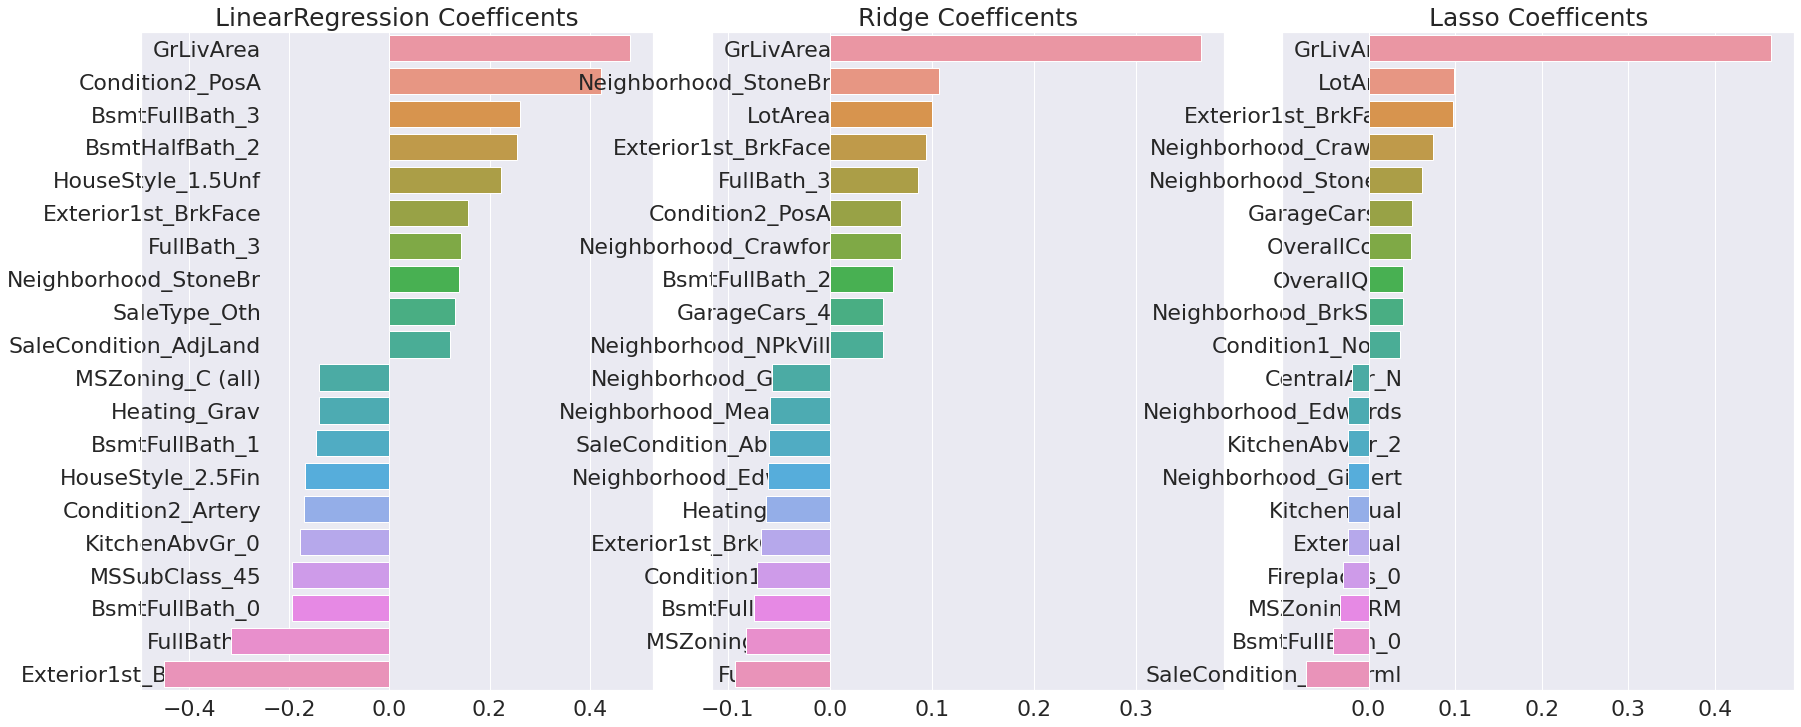

In [ ]:
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

In [ ]:
#### 트리기반 모델 ####
xgb_params = {'n_estimators': [700, 800, 900, 1000],
              'learning_rate': [0.01, 0.03, 0.05],
              'colsample_bytree': [0.1, 0.3, 0.5],
              'subsample': [0.1, 0.3, 0.5]}

lgbm_params = {'n_estimators': [700, 800, 900, 1000],
              'learning_rate': [0.01, 0.03, 0.05],
              'colsample_bytree': [0.1, 0.3, 0.5],
              'subsample': [0.1, 0.3, 0.5]}

cat_params = {'depth': [4, 5, 6],
             'learning_rate': [0.03, 0.05, 0.07],
             'iterations': [50, 100]}

In [ ]:
xgb = XGBRegressor()
lgbm = LGBMRegressor(n_jobs = -1)
cat = CatBoostRegressor()

In [ ]:
# best_xgb = print_best_params(xgb, xgb_params)
# best_lgbm = print_best_params(lgbm, lgbm_params)
# best_cat = print_best_params(cat, cat_params)

In [ ]:
xgb_reg = XGBRegressor(n_estimators = 1000, learning_rate = 0.03, colsample_bytree = 0.3, subsample = 0.5)
xgb_reg.fit(X_train, y_train)

lgbm_reg = LGBMRegressor(n_estimators = 1000, learning_rate = 0.01, colsample_bytree = 0.3, subsample = 0.1, n_jobs = -1)
lgbm_reg.fit(X_train, y_train)

cat_reg = CatBoostRegressor(depth = 6, iterations = 100, learning_rate = 0.05)
cat_reg.fit(X_train, y_train)

[01:37:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0:	learn: 0.3561941	total: 61.5ms	remaining: 6.09s
1:	learn: 0.3450651	total: 78.6ms	remaining: 3.85s
2:	learn: 0.3349461	total: 95.4ms	remaining: 3.08s
3:	learn: 0.3258268	total: 114ms	remaining: 2.73s
4:	learn: 0.3160079	total: 123ms	remaining: 2.34s
5:	learn: 0.3076788	total: 137ms	remaining: 2.14s
6:	learn: 0.2986692	total: 149ms	remaining: 1.97s
7:	learn: 0.2905771	total: 157ms	remaining: 1.8s
8:	learn: 0.2829544	total: 163ms	remaining: 1.65s
9:	learn: 0.2754889	total: 178ms	remaining: 1.6s
10:	learn: 0.2680064	total: 189ms	remaining: 1.53s
11:	learn: 0.2606667	total: 200ms	remaining: 1.46s
12:	learn: 0.2540040	total: 210ms	remaining: 1.41s
13:	learn: 0.2483042	total: 222ms	remaining: 1.36s
14:	learn: 0.2424286	total: 233ms	remaining: 1.32s
15:	learn: 0.2367373	total: 246ms	remaining: 1.29s
16:	learn: 0.2314191	total: 255ms	remaining: 1.25s
17:	learn: 0.22

In [ ]:
models = [xgb_reg, lgbm_reg, cat_reg]
get_rmses(models)
get_r2(models)

XGBRegressor 로그 변환된 RMSE :  0.1091
LGBMRegressor 로그 변환된 RMSE :  0.1185
CatBoostRegressor 로그 변환된 RMSE :  0.1368
XGBRegressor
train(cv) R2_score :  0.9794981687060366
test(cv) R2_score :  0.9218446625355773
-------------------------
LGBMRegressor
train(cv) R2_score :  0.9845774321129684
test(cv) R2_score :  0.9077654407827954
-------------------------
CatBoostRegressor
train(cv) R2_score :  0.9185700638813692
test(cv) R2_score :  0.8771049204162715
-------------------------


# 변수 중요도

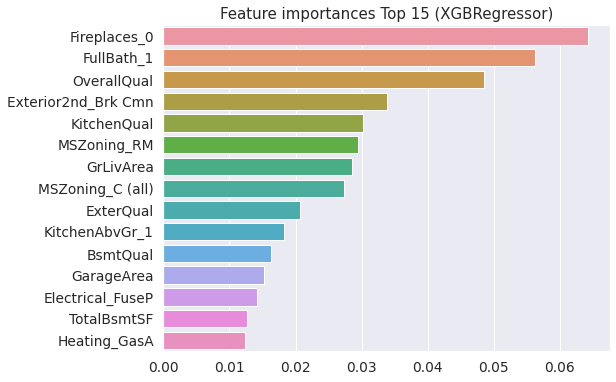

In [ ]:
# xgboost 변수 중요도 추출
gbcl_importances_values = xgb_reg.feature_importances_
gbcl_importances = pd.Series(gbcl_importances_values, index=X_train.columns)
gbcl_top20 = gbcl_importances.sort_values(ascending=False)[:15]

plt.figure(figsize=(8, 6))
plt.title('Feature importances Top 15 (XGBRegressor)')
sns.barplot(x=gbcl_top20, y=gbcl_top20.index)
plt.show()

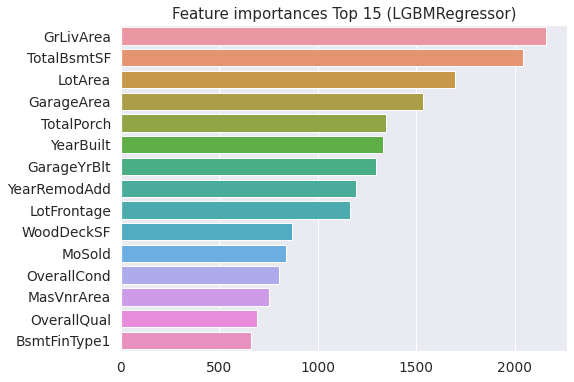

In [ ]:
# lightgbm 변수 중요도 추출

gbcl_importances_values = lgbm_reg.feature_importances_
gbcl_importances = pd.Series(gbcl_importances_values, index=X_train.columns)
gbcl_top20 = gbcl_importances.sort_values(ascending=False)[:15]

plt.figure(figsize=(8, 6))
plt.title('Feature importances Top 15 (LGBMRegressor)')
sns.barplot(x=gbcl_top20, y=gbcl_top20.index)
plt.show()

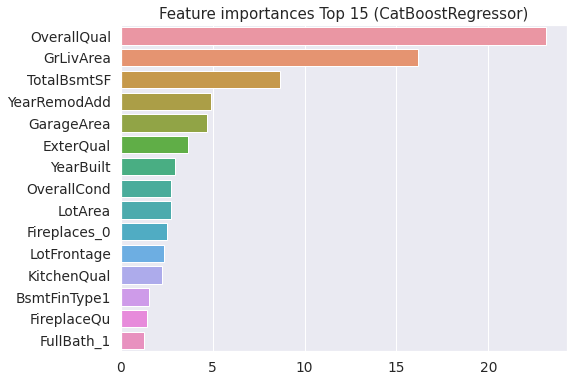

In [ ]:
# cat_reg 변수 중요도 추출

gbcl_importances_values = cat_reg.feature_importances_
gbcl_importances = pd.Series(gbcl_importances_values, index=X_train.columns)
gbcl_top20 = gbcl_importances.sort_values(ascending=False)[:15]

plt.figure(figsize=(8, 6))
plt.title('Feature importances Top 15 (CatBoostRegressor)')
sns.barplot(x=gbcl_top20, y=gbcl_top20.index)
plt.show()